<a href="https://colab.research.google.com/github/cras-lab/Finance1/blob/main/%EC%8B%9C%EA%B3%84%EC%97%B4_%EA%B5%AC%EC%84%B1%EC%9A%94%EC%86%8C%EC%99%80_1%EC%B0%A8%EC%B0%A8%EB%B6%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

시계열 분석을 위해 yfinance를 설치한다.

In [2]:
pip install -q yfinance

필요한 모듈을 import 한다.

In [20]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

야후 finance의 Open API를 사용하여, 삼성전자 주가를 불러 온다.

In [61]:
Tickers = [ '^KS11', '^GSPC']
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 1, 1)
df = yf.download(Tickers, start=start, end=end, interval='1mo').Close
Prices = [ df['^GSPC'], df[ '^KS11']]

[*********************100%***********************]  2 of 2 completed


시계열의 각 구성요소를 시각화 해 본다.

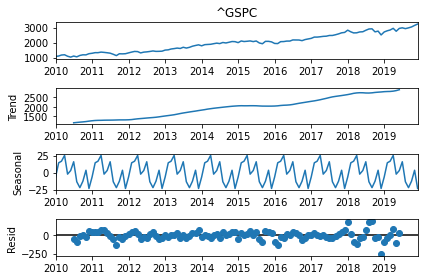

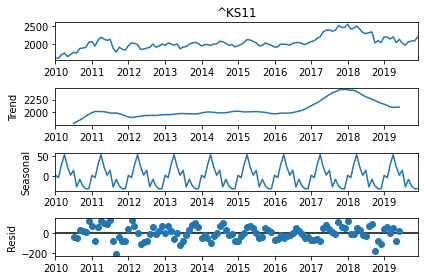

In [62]:
seasonal_decompose(Prices[0], period=12).plot()
seasonal_decompose(Prices[1], period=12).plot()
plt.show()

추세: 시작점과 끝점이 다르거나, 시계열에서 상승/하향 기울기를 가질때 나타난다.
S&P와 KOSPI가 각각 어떤 추세를 가지는지 살펴보자.

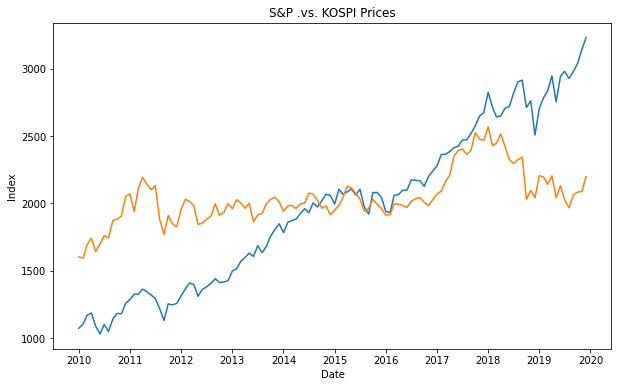

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(Prices[0])
plt.plot(Prices[1])
plt.title('S&P .vs. KOSPI Prices')
plt.ylabel('Index')
plt.xlabel('Date')
plt.show()

자기상관과 부분자기상관 관계를 살펴보면, 현재 값과 과거 값 사이의 종속성을 볼 수 있다.추세가 있다고 반드시 자기상관이 생기는 것은 아니지만, 자기 상관이 있을 개연성이 높다.

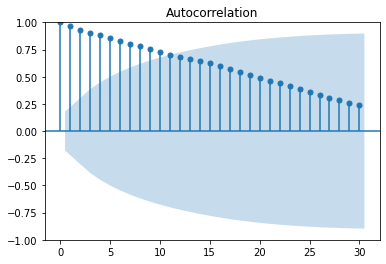

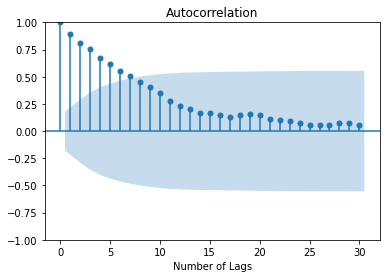

In [77]:
sm.graphics.tsa.plot_acf(Prices[0], lags=30)
sm.graphics.tsa.plot_acf(Prices[1], lags=30)
plt.xlabel('Number of Lags')
plt.show()

부분 자기상관 관계를 살펴보자.
부분 상관계수는 다른 변수들의 영향을 제거하고 두 변수가 다른 변수들로부터 독립적으로 얼마나 관련성을 가지는지의 지표

EX) A, B가 양의 상관관계를 가지고 , C가 A,B 모두와 양의 상관관계를 가진다고 가정할 때, C의 영향을 제거하지 않으면, A와 B의 상관관계는 실제보다 높게 나타날 수 있다. A와 B 사이의 부분상관관계수를 계산하면, C의 영향을 제거하고 A와 B 사이의 상관관계를 보다 정확하게 파악할 수 있다.
일반적으로는 Yule-Walker 방정식이나 Durbin-Levinson 알고리즘 등을 사용한다. 

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


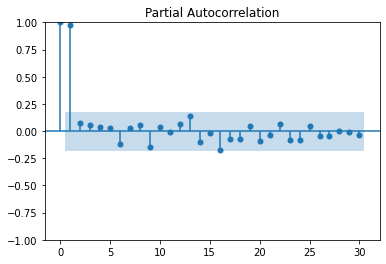

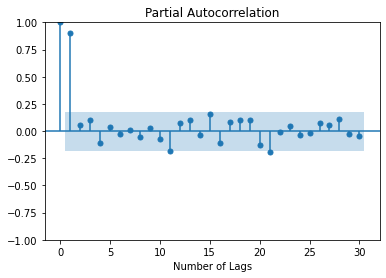

In [78]:
sm.graphics.tsa.plot_pacf(Prices[0], lags=30)
sm.graphics.tsa.plot_pacf(Prices[1], lags=30)
plt.xlabel('Number of Lags')
plt.show()

차분을 하는 것 만으로도 정상성을 어느 정도 확보할 수 있다.

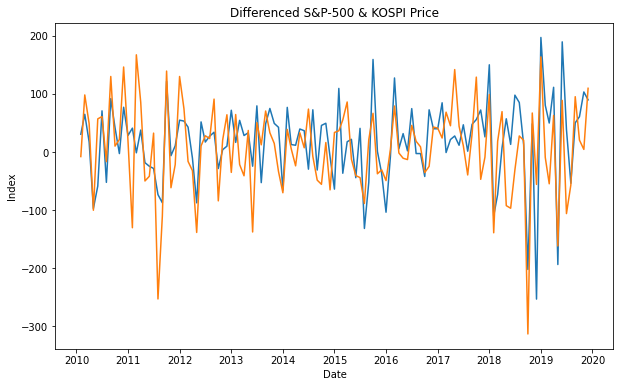

In [79]:
df_diff = df.diff()
diff_Prices = [ df_diff[ '^GSPC'] , df_diff['^KS11'] ]
plt.figure(figsize=(10, 6))
plt.plot(diff_Prices[0])
plt.plot(diff_Prices[1])
plt.title('Differenced S&P-500 & KOSPI Price')
plt.ylabel('Index')
plt.xlabel('Date')
plt.show()

차분한 값들의 자기상관 그래프를 그려보자.

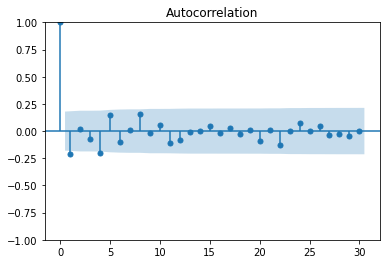

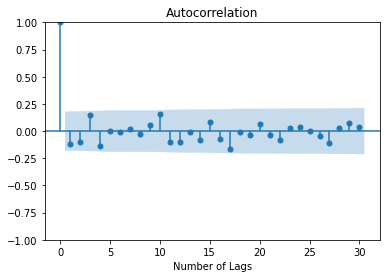

In [80]:
sm.graphics.tsa.plot_acf(diff_Prices[0].dropna(),lags=30)
sm.graphics.tsa.plot_acf(diff_Prices[1].dropna(),lags=30)
plt.xlabel('Number of Lags')
plt.show()

차분한 값들의 부분 자기상관관계도 그래프로 그려보자.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


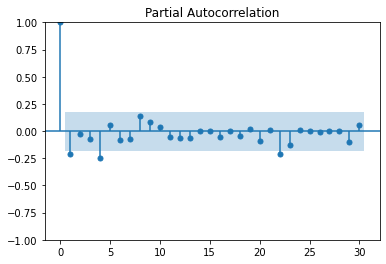

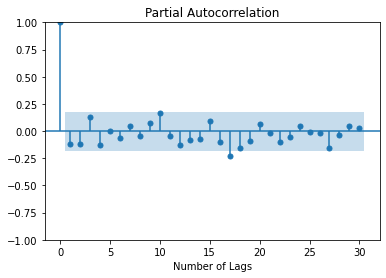

In [82]:
sm.graphics.tsa.plot_pacf(diff_Prices[0].dropna() , lags=30)
sm.graphics.tsa.plot_pacf(diff_Prices[1].dropna() , lags=30)
plt.xlabel('Number of Lags')
plt.show()